In [2]:
# librerias:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import numpy as np
from tqdm.notebook import tqdm
import gc

import warnings
warnings.filterwarnings("ignore")

from lightgbm import LGBMClassifier,LGBMRegressor, LGBMRanker
from xgboost import XGBClassifier,XGBRegressor
from catboost import CatBoostClassifier,CatBoostRegressor

import os
import sweetviz as sv

from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold, train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_log_error,mean_squared_error,f1_score
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

In [3]:
import lightgbm as lgb

In [4]:
train = pd.read_csv('../data/train_ratings.csv', low_memory=False)
test  = pd.read_csv('../data/test_ratings.csv', low_memory=False)
users = pd.read_csv('../data/users.csv', low_memory=False)
books = pd.read_csv('../data/books.csv', low_memory=False)
sample_submission = pd.read_csv('../data/sample_submission.csv', low_memory=False)

In [5]:
def preprocess_book(df):
    vals_year   = df[df['year'].isin(['DK Publishing Inc','Gallimard'])]['author'].values 
    vals_author = df[df['year'].isin(['DK Publishing Inc','Gallimard'])]['year'].values 
    df.loc[df['year'].isin(['DK Publishing Inc','Gallimard']),'year'] = vals_year
    df.loc[df['year'].isin(['DK Publishing Inc','Gallimard']),'author'] = vals_author
    df['year'] = df['year'].astype(float)
#     df.loc[df['year'] == 0, 'year'] = np.nan
    return df

books = preprocess_book(books)

In [6]:
train = train.merge(users, how='left').merge(books, how='left')
test = test.merge(users, how='left').merge(books, how='left')

In [7]:
vars_cat = ["city","province","country","title","author","publisher"]
for col in vars_cat:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

### Modelo

In [8]:
# Variables finales que entrarian al modelo:
vars_in = [f for f in train.columns if f not in ['id','user_id','book_id','rating']]
print(vars_in)

['age', 'city', 'province', 'country', 'title', 'author', 'year', 'publisher']


In [9]:
train['rating'].value_counts().sort_index()

1       962
2      1543
3      3327
4      4949
5     29475
6     20591
7     43147
8     59657
9     39496
10    46279
Name: rating, dtype: int64

<AxesSubplot:>

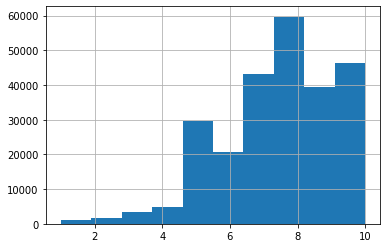

In [10]:
train['rating'].hist()

In [11]:
# Particionando la muestra en train(70%) y test (30%)
train_x, valid_x, train_y, valid_y = train_test_split(train[vars_in],
                                                      train["rating"],
                                                      test_size=0.25,
                                                      shuffle=True,
                                                      random_state=456,
                                                      stratify=train["rating"])
# train_y -= 1
# valid_y -= 1

In [213]:
# train_y = train_y.map({
#     1:  3,
#     2:  3,
#     3:  3,
#     4:  3,
#     5:  5,
#     6:  5,
#     7:  8,
#     8:  8,
#     9:  10,
#     10: 10,
# })

# valid_y2 = valid_y.map({
#     1:  3,
#     2:  3,
#     3:  3,
#     4:  3,
#     5:  5,
#     6:  5,
#     7:  8,
#     8:  8,
#     9:  10,
#     10: 10,
# })

In [54]:
# Parametros del LightGBM
model1 = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.03,
        boosting_type= 'gbdt',
        objective='multiclass',
        colsample_bytree=.8,
        subsample=.8,
        max_depth=5,
        num_class=10
        #feval = row_wise_f1_score_micro
        )

# Entrenamiento:
model1.fit(train_x, train_y,
            eval_set= [(train_x, train_y), (valid_x, valid_y)], 
            categorical_feature = vars_cat,
            eval_metric=['multi_error'],
            verbose=25,
            early_stopping_rounds=100,
            #feval = row_wise_f1_score_micro
           )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[25]	training's multi_error: 0.696032	training's multi_logloss: 1.79898	valid_1's multi_error: 0.704315	valid_1's multi_logloss: 1.82524
[50]	training's multi_error: 0.681465	training's multi_logloss: 1.75741	valid_1's multi_error: 0.698398	valid_1's multi_logloss: 1.80421
[75]	training's multi_error: 0.66955	training's multi_logloss: 1.72923	valid_1's multi_error: 0.695335	valid_1's multi_logloss: 1.79368
[100]	training's multi_error: 0.661045	training's multi_logloss: 1.70765	valid_1's multi_error: 0.693892	valid_1's multi_logloss: 1.78814
[125]	training's multi_error: 0.652818	training's multi_logloss: 1.68977	valid_1's multi_error: 0.69248	valid_1's multi_logloss: 1.78464
[150]	training's multi_error: 0.646457	training's multi_logloss: 1.67432	valid_1's multi_error: 0.691903	valid_1's multi_lo

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.03, max_depth=5,
               n_estimators=10000, num_class=10, objective='multiclass',
               subsample=0.8)

In [14]:
predict_train1 = model1.predict(valid_x)

In [53]:
predict_train1_f = pd.Series(predict_train1)
predict_train1_f = predict_train1_f.map({
    1:  1,
    2:  2,
    3:  3,
    4:  4,
    5:  5,
    6:  6,
    7:  7,
    8:  8,
    9:  9,
    10: 10,
})


f1_score(valid_y,predict_train1_f,average="micro")*100

30.93798611222477

<AxesSubplot:>

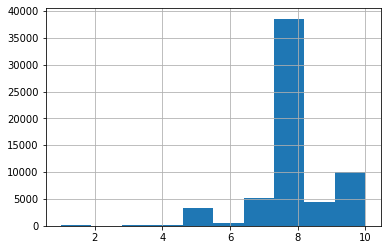

In [17]:
pd.Series(predict_train1).hist()

<AxesSubplot:>

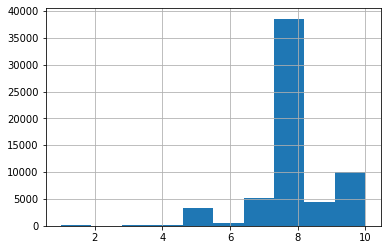

In [194]:
pd.Series(predict_train1).hist()

In [187]:
model2 = LGBMRegressor(
        n_estimators=10000,
        learning_rate=0.03,
        boosting_type= 'gbdt',
#         objective='multiclass',
        colsample_bytree=.8,
        subsample=.8,
        max_depth=5,
#         num_class=3
        #feval = row_wise_f1_score_micro
        )

# Entrenamiento:
model2 = param.fit(train_x, train_y, 
                eval_set= [(train_x, train_y), (valid_x, valid_y)], 
                categorical_feature = vars_cat,
#                 eval_metric=['multi_error'],
                verbose=25,
                early_stopping_rounds=100,
                #feval = row_wise_f1_score_micro
               )

Training until validation scores don't improve for 100 rounds
[25]	training's l2: 3.20214	valid_1's l2: 3.21811
[50]	training's l2: 3.11384	valid_1's l2: 3.14224
[75]	training's l2: 3.06049	valid_1's l2: 3.10055
[100]	training's l2: 3.02274	valid_1's l2: 3.0738
[125]	training's l2: 2.99472	valid_1's l2: 3.0555
[150]	training's l2: 2.96651	valid_1's l2: 3.03702
[175]	training's l2: 2.94211	valid_1's l2: 3.02167
[200]	training's l2: 2.92189	valid_1's l2: 3.00941
[225]	training's l2: 2.90445	valid_1's l2: 3.00023
[250]	training's l2: 2.88678	valid_1's l2: 2.99042
[275]	training's l2: 2.87204	valid_1's l2: 2.98277
[300]	training's l2: 2.85725	valid_1's l2: 2.97427
[325]	training's l2: 2.84256	valid_1's l2: 2.96717
[350]	training's l2: 2.82994	valid_1's l2: 2.96127
[375]	training's l2: 2.81796	valid_1's l2: 2.9556
[400]	training's l2: 2.80588	valid_1's l2: 2.94948
[425]	training's l2: 2.79441	valid_1's l2: 2.94406
[450]	training's l2: 2.78375	valid_1's l2: 2.939
[475]	training's l2: 2.77407

In [190]:
predict_train2 = model2.predict(valid_x)
f1_score(valid_y,predict_train2.round(),average="micro")*100

25.105441249579037

In [192]:
quantiles = train.loc[train_x.index, 'rating'].value_counts(normalize=True).sort_index().cumsum()
quantiles = list(quantiles)
predict_train2_2 = pd.qcut(predict_train, [0] + quantiles, labels=np.arange(1, 11, 1)).astype(int)
f1_score(valid_y,predict_train2_2,average="micro")*100

24.664432220921466

In [201]:
predict_train_1_2 = predict_train1 + predict_train2/predict_train2.max()
predict_train_1_2 = pd.qcut(predict_train_1_2, [0] + quantiles, labels=np.arange(1, 11, 1)).astype(int)
f1_score(valid_y,predict_train_1_2,average="micro")*100

24.872909216286864

<AxesSubplot:>

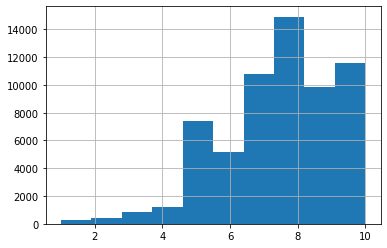

In [202]:
pd.Series(predict_train_1_2).hist()

In [206]:
f1_score(valid_y,predict_train_1_2,average="micro")*100

23.91712237599628

In [196]:
predict_train1

array([ 7,  8,  8, ...,  8, 10,  8])

In [200]:
predict_train2

array([6.92463731, 8.43166876, 7.59671342, ..., 6.7492077 , 8.02697581,
       7.97460193])

In [203]:
predict_train_1_2

array([ 5,  9,  8, ...,  6, 10,  8])

In [122]:
# def f1_score_micro(preds, data):
#     labels = data.get_label()
#     preds = preds.reshape(len(np.unique(labels)), -1)
#     preds = preds.argmax(axis = 0)
#     return 'f1_score_micro', f1_score(labels, preds, average='micro'), True

In [61]:
# MODEL_PARAMS_LGB = {
#     'n_estimators': 10000,
#     'learning_rate': 0.03,
#     'boosting_type': 'gbdt',
#     'objective': 'multiclass',
#     'colsample_bytree': .8,
#     'subsample': .8,
#     'max_depth': 5,
#     'num_class': 10,
# }
# FIT_PARAMS_LGB = {"early_stopping_rounds": 100, "verbose_eval":25,}

# lgb_tr = lgb.Dataset(train_x, train_y)
# lgb_val = lgb.Dataset(valid_x, valid_y)

# model = lgb.train(
#     MODEL_PARAMS_LGB, lgb_tr, **FIT_PARAMS_LGB,
#     valid_names=['train', 'valid'], valid_sets=[lgb_tr, lgb_val],
#     fobj=None,
#     feval=f1_score_micro  # <= set custom metric function
# )

In [115]:
sub_train = train.loc[train_x.index].groupby('user_id')['rating'].agg(['count', 'mean', 'std'])
sub_train['coef_var'] = sub_train['std'] / sub_train['mean']
idx = (sub_train['count'] > 0) & (sub_train['coef_var'] < 9)
overwrite = sub_train[idx]['mean'].round()
overwrite

user_id
00038787e6    8.0
00063cb5da    7.0
000836ac15    7.0
000d20cbc6    5.0
000f564b70    8.0
             ... 
fff6a9143a    8.0
fff6b0bf88    7.0
fffa709684    8.0
fffe1ddcc0    8.0
fffea28543    5.0
Name: mean, Length: 18216, dtype: float64

In [117]:
train.loc[valid_y.index, 'user_id']

223340    89429e811b
104657    615135c0cb
138814    08eac1d7ee
149848    27a8c2ba1c
183747    00005d011d
             ...    
219934    4e33d5d7de
36492     ae47369a1a
210756    de65a3fb6d
45324     c0bc33be2e
215806    3ffb3ca718
Name: user_id, Length: 62357, dtype: object

In [118]:
sub_test = pd.DataFrame(predict_train1.copy(), valid_y.index, columns=['rating'])
sub_test['user_id'] = train.loc[valid_y.index, 'user_id']
sub_test['rating_overwrite'] = sub_test['user_id'].map(overwrite)
sub_test['rating_final'] = sub_test['rating_overwrite'].fillna(sub_test['rating']).astype(int)
sub_test

,rating,user_id,rating_overwrite,rating_final
223340,7,89429e811b,7.0,7
104657,8,615135c0cb,NaN,8
138814,8,08eac1d7ee,8.0,8
149848,8,27a8c2ba1c,9.0,9
183747,5,00005d011d,NaN,5
...,...,...,...,...
219934,8,4e33d5d7de,NaN,8
36492,8,ae47369a1a,NaN,8
210756,8,de65a3fb6d,7.0,7
45324,10,c0bc33be2e,9.0,9


In [119]:
f1_score(valid_y,sub_test['rating_final'],average="micro")*100

27.385858845037447

In [ ]:
# Haciendo la prediccion:
predict_train = lgbm_model.predict(valid_x)
print(predict_train)

In [174]:
predict_train_f = predict_train.round()
print(predict_train_f)

[7. 8. 8. ... 7. 8. 8.]


In [150]:
f1_score(valid_y,predict_train_f,average="micro")*100

25.105441249579037

<AxesSubplot:>

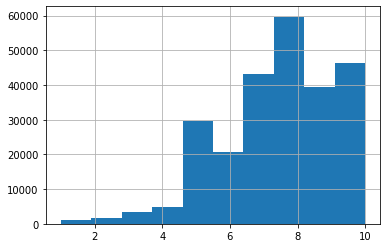

In [157]:
train['rating'].hist()

In [169]:
quantiles = train['rating'].value_counts(normalize=True).sort_index().cumsum()
quantiles = list(quantiles)
quantiles

[0.0038568553398603193,
 0.010043058863149792,
 0.02338168434726131,
 0.043223240560326504,
 0.1613945619141549,
 0.2439481048487327,
 0.4169332788081435,
 0.6561104295462382,
 0.8144579955578007,
 1.0]

<AxesSubplot:>

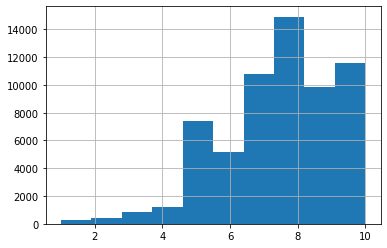

In [180]:
pd.Series(predict_train_f).hist()

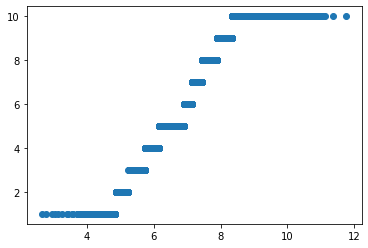

In [184]:
plt.scatter(predict_train, predict_train_f)

In [178]:
# Ajuste a la Distribución
predict_train_f = pd.qcut(predict_train, [0] + quantiles, labels=np.arange(1, 11, 1)).astype(int)

f1_score(valid_y,predict_train_f,average="micro")*100

24.664432220921466

In [80]:
dict(sorted(zip(lgbm_model.feature_name_, lgbm_model.booster_.feature_importance(importance_type='gain')),
                       key=lambda item: item[1],
                       reverse=True
                      )
               )

{'city': 716607.2711709738,
 'author': 241180.72864809632,
 'publisher': 165328.17694443278,
 'title': 147207.67823186517,
 'age': 121038.03687195724,
 'province': 104673.46620615572,
 'year': 72369.893368356,
 'country': 8607.884432792664}

In [18]:
# Haciendo la prediccion:
predict_test = lgbm_model.predict(test[vars_in])

In [19]:
submission_test = pd.DataFrame({'id':test["id"],
                                 'rating':predict_test})
submission_test.head()

,id,rating
0,f38f854b31509133,8
1,aadb34054d6c8a12,8
2,87b031bdd906e26d,8
3,371562c1c36bb8d5,8
4,3ebb7df64a2896be,8


In [1]:
import pandas as pd
import numpy as np
import sweetviz as sv

In [5]:
# train2 = train.copy()

# for col in ['city', 'province', 'country', 'title', 'author', 'publisher']:
#     idx = np.array(train2[col].isin(test[col].unique()).loc[lambda x: ~x].index)
#     train2.drop(index=idx, inplace=True)

In [6]:
all_interactions = pd.concat([train[['user_id', 'book_id', 'rating']], test[['user_id', 'book_id']].assign(rating=0)])
sample_user_id = pd.Series(all_interactions['user_id'].unique()).sample(n=10000, random_state=4).values
all_interactions = all_interactions[all_interactions['user_id'].isin(sample_user_id)]

pivot_interactions = all_interactions.pivot_table('rating', 'user_id', 'book_id')
pivot_interactions

book_id,0000694cce,0005eca48c,00092574c6,00096fc1b4,000c4b34c1,000d218a64,000fcede56,001425d200,00197a36cd,001a8c395c,...,ffea0e8767,ffea679bfc,ffec52a88e,ffeff5d6e9,fff2518ddf,fff7436599,fff910c0a6,fff96e5833,fffb9ddc28,fffcf3cfa2
user_id,,,,,,,,,,,,,,,,,,,,,
00005d011d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0001796186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00038787e6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0005cd3c50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0007f1d62c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffe39a737d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fff38493f5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fff8db9478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
all_interactions.sort_values('user_id').to_clipboard()

In [ ]:
pivot_interactions

In [24]:
all_interactions

,user_id,book_id,rating
0,9db527ea34,69173ee3b6,5
1,3db2595a13,58d33fe06a,8
2,375781e597,512b5d69de,10
3,f00ee6360d,98c1419160,9
4,8b893fb104,99c56ce036,9
...,...,...,...
134302,598825e90a,29f4516f72,0
134303,0e1ff052ae,d27721acf2,0
134304,0baec5a22d,121a671e06,0
134305,967874531a,c414ce067b,0


In [7]:
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

In [ ]:
features = ['age', 'city', 'province', 'country', 'title', 'author', 'year', 'publisher']
target = 'rating'

for col in features:
    df_train[col] = df_train[col].map(lambda x: int(x.split('_')[-1]))
    df_test[col] = df_test[col].map(lambda x: int(x.split('_')[-1]))

X = df_train[features]
y = df_train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
train.columns

Index(['id', 'user_id', 'book_id', 'rating', 'age', 'city', 'province',
       'country', 'title', 'author', 'year', 'publisher'],
      dtype='object')

In [21]:
train

,id,user_id,book_id,rating,age,city,province,country,title,author,year,publisher
1,9ecc1d4a2e9a7476,3db2595a13,58d33fe06a,8,41.0,romney,west virginia,usa,The No. 1 Ladies' Detective Agency (Today Show...,Alexander McCall Smith,2003.0,Anchor
3,617ef107e6ffed5a,f00ee6360d,98c1419160,9,NaN,san diego,,usa,The Summons,John Grisham,2002.0,Dell Publishing Company
4,0e2be280941c4d1f,8b893fb104,99c56ce036,9,26.0,springfield,missouri,usa,"Starman (The Axis Trilogy, Bk 3)",Sara Douglass,2002.0,Tor Books
6,efbb30ccb29583c4,3ae810fa9d,e0aa3f0fc0,9,29.0,porto,porto,portugal,Celtic Fairy Tales,Joseph Jacobs,NaN,Parragon
7,c95da7fa58219065,0405213304,9392a59e6a,4,NaN,irvine,california,NaN,The Reef,Nora Roberts,1999.0,Jove Books
...,...,...,...,...,...,...,...,...,...,...,...,...
249419,6dbfef61c2fc29fa,1a8a4f0b39,402a0ed40f,9,NaN,providence,rhode island,usa,The Practical Encycopedia of Feng Shui,Gill Hale,2001.0,Hermes House
249420,0454a4c5989ef6c6,5238703487,c13d6aa85e,7,37.0,köln,nordrhein-westfalen,germany,"Fischer TaschenbÃ?Â¼cher, Bd.26, SchÃ?Â¶ne neu...",Aldous Huxley,2002.0,"Fischer (Tb.), Frankfurt"
249421,b9a8ff87e1cd3db7,239f28d3df,20a149064d,10,42.0,janesville,california,usa,Against the Odds,Elizabeth Moon,2001.0,Baen
249424,0204e100e468d273,605e3aa44a,3d7ad0d1d2,6,NaN,cleveland,ohio,usa,The Last Family,John R. Miller,1997.0,Bantam Books


In [ ]:
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)